# HopfieldNetwork

저장된 패턴의 개수: 3
네트워크 뉴런 수: 25
가중치 행렬 크기: (25, 25)

--- 패턴 복구 시뮬레이션 (대상: 패턴 1) ---
노이즈 레벨: 20.0%


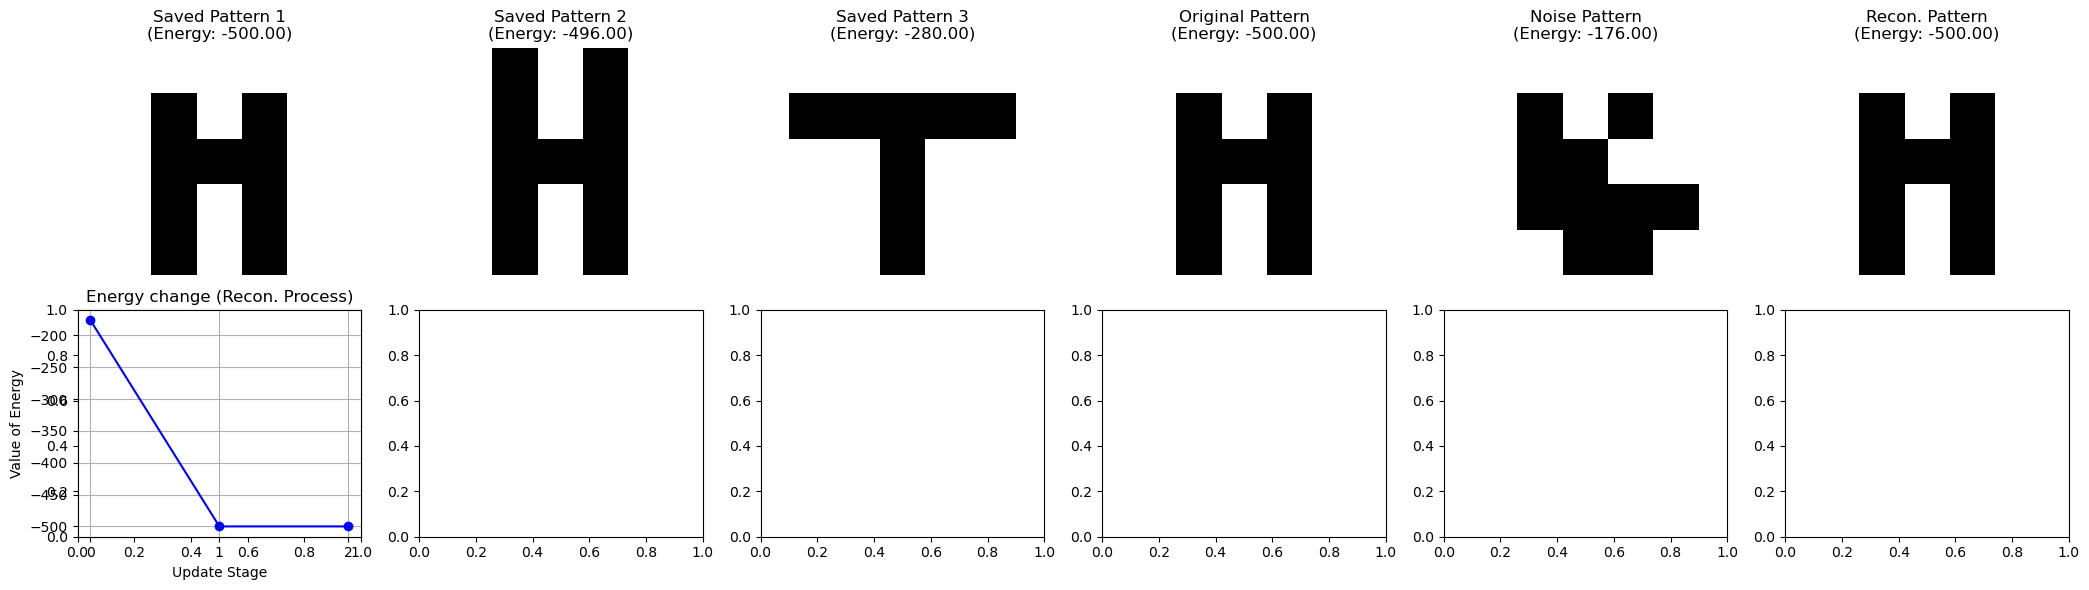


--- 복구 과정의 중간 단계 (초기, 중간, 최종) ---


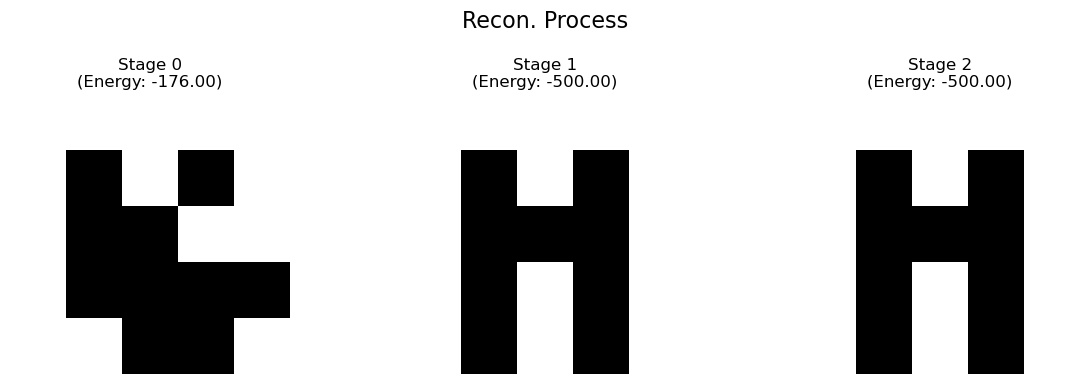


패턴 복구 성공! 노이즈가 있는 패턴이 원래 패턴으로 정확히 수렴했습니다.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 홉필드 네트워크 클래스 정의
class HopfieldNetwork:
    def __init__(self, num_neurons):
        self.num_neurons = num_neurons
        self.weights = np.zeros((num_neurons, num_neurons))

    def train(self, patterns):
        """
        패턴을 학습하여 가중치 행렬을 설정합니다.
        patterns: 리스트 형태의 2D numpy 배열. 각 배열은 (num_neurons,) 형태의 이진 패턴.
        """
        for p in patterns:
            # 패턴을 1D 벡터로 평탄화 (2D 이미지를 가정)
            p_flat = p.flatten()
            # 헤비안 학습 규칙: W_ij = sum(p_k_i * p_k_j)
            # 자기 연결 (i=j)은 0으로 설정
            self.weights += np.outer(p_flat, p_flat)
        np.fill_diagonal(self.weights, 0) # 자기 연결은 0으로 설정

    def calculate_energy(self, state):
        """
        주어진 상태(state)에 대한 에너지 값을 계산합니다.
        E = -0.5 * sum(W_ij * s_i * s_j)
        state: (num_neurons,) 형태의 이진 벡터
        """
        state_flat = state.flatten()
        return -0.5 * np.dot(state_flat.T, np.dot(self.weights, state_flat))

    def retrieve(self, initial_state, max_iterations=100):
        """
        노이즈가 있는 초기 상태로부터 패턴을 복구합니다.
        비동기 업데이트 방식을 사용합니다.
        """
        current_state = initial_state.copy().flatten()
        energy_history = [self.calculate_energy(current_state)]
        state_history = [current_state.copy().reshape(self.pattern_shape)]

        for _ in range(max_iterations):
            prev_state = current_state.copy()
            # 뉴런을 무작위 순서로 업데이트
            random_indices = np.random.permutation(self.num_neurons)
            for i in random_indices:
                # 뉴런 i에 대한 순 입력 계산
                net_input = np.dot(self.weights[i, :], current_state)
                # 활성화 함수 (부호 함수) 적용
                current_state[i] = 1 if net_input >= 0 else -1 # 1 또는 -1

            current_energy = self.calculate_energy(current_state)
            energy_history.append(current_energy)
            state_history.append(current_state.copy().reshape(self.pattern_shape))

            # 상태가 더 이상 변하지 않으면 수렴으로 간주
            if np.array_equal(current_state, prev_state):
                break
        return current_state.reshape(self.pattern_shape), energy_history, state_history

# 2. 패턴 정의 (흑백 이미지 패턴, 5x5 픽셀)
# 각 픽셀은 1 (흰색) 또는 -1 (검은색)
# 패턴1: A (대문자 A와 유사)
pattern1 = np.array([
    [-1, -1, -1, -1, -1],
    [-1,  1, -1,  1, -1],
    [-1,  1,  1,  1, -1],
    [-1,  1, -1,  1, -1],
    [-1,  1, -1,  1, -1]
])

# 패턴2: H (대문자 H와 유사)
pattern2 = np.array([
    [-1,  1, -1,  1, -1],
    [-1,  1, -1,  1, -1],
    [-1,  1,  1,  1, -1],
    [-1,  1, -1,  1, -1],
    [-1,  1, -1,  1, -1]
])

# 패턴3: T (대문자 T와 유사)
pattern3 = np.array([
    [-1, -1, -1, -1, -1],
    [ 1,  1,  1,  1,  1],
    [-1, -1,  1, -1, -1],
    [-1, -1,  1, -1, -1],
    [-1, -1,  1, -1, -1]
])

stored_patterns = [pattern1, pattern2, pattern3]
pattern_shape = stored_patterns[0].shape
num_neurons = pattern_shape[0] * pattern_shape[1]

# 3. 홉필드 네트워크 초기화 및 학습
hopfield_net = HopfieldNetwork(num_neurons)
hopfield_net.pattern_shape = pattern_shape # 시각화를 위해 저장
hopfield_net.train(stored_patterns)

print(f"저장된 패턴의 개수: {len(stored_patterns)}")
print(f"네트워크 뉴런 수: {num_neurons}")
print(f"가중치 행렬 크기: {hopfield_net.weights.shape}")

# 4. 노이즈 주입 및 복구 시뮬레이션
# 패턴1을 복구 대상으로 선택
target_pattern_index = 0
target_pattern = stored_patterns[target_pattern_index]

# 노이즈 주입 (예: 20% 픽셀 반전)
noise_level = 0.2
noisy_pattern = target_pattern.copy().flatten()
num_flips = int(num_neurons * noise_level)
flip_indices = np.random.choice(num_neurons, num_flips, replace=False)
noisy_pattern[flip_indices] *= -1 # 픽셀 값 반전 (1 -> -1, -1 -> 1)
noisy_pattern = noisy_pattern.reshape(pattern_shape)

print(f"\n--- 패턴 복구 시뮬레이션 (대상: 패턴 {target_pattern_index+1}) ---")
print(f"노이즈 레벨: {noise_level*100}%")

recovered_pattern, energy_history, state_history = hopfield_net.retrieve(noisy_pattern)

# 5. 결과 시각화
total_cols = len(stored_patterns) + 3 # 상단 이미지 총 열의 개수
fig, axes = plt.subplots(2, total_cols, figsize=(15 + 2 * len(stored_patterns), 6))
# 폰트 깨짐 방지
#plt.rcParams['font.family'] = 'Malgun Gothic'
#plt.rcParams['axes.unicode_minus'] = False


# 저장된 패턴 시각화
for i, pattern in enumerate(stored_patterns):
    ax = axes[0, i]
    ax.imshow(pattern, cmap='binary', interpolation='nearest')
    ax.set_title(f'Saved Pattern {i+1}\n(Energy: {hopfield_net.calculate_energy(pattern):.2f})')
    ax.axis('off')

# 초기, 노이즈, 복구된 패턴 시각화
axes[0, len(stored_patterns)].imshow(target_pattern, cmap='binary', interpolation='nearest')
axes[0, len(stored_patterns)].set_title(f'Original Pattern\n(Energy: {hopfield_net.calculate_energy(target_pattern):.2f})')
axes[0, len(stored_patterns)].axis('off')

axes[0, len(stored_patterns)+1].imshow(noisy_pattern, cmap='binary', interpolation='nearest')
axes[0, len(stored_patterns)+1].set_title(f'Noise Pattern\n(Energy: {energy_history[0]:.2f})')
axes[0, len(stored_patterns)+1].axis('off')

axes[0, len(stored_patterns)+2].imshow(recovered_pattern, cmap='binary', interpolation='nearest')
axes[0, len(stored_patterns)+2].set_title(f'Recon. Pattern\n(Energy: {energy_history[-1]:.2f})')
axes[0, len(stored_patterns)+2].axis('off')

# 에너지 변화 그래프
# 모든 하단 열을 한 개의 서브플롯으로 합치기
ax_energy = fig.add_subplot(2, total_cols, (total_cols + 1)) # nrows=2, ncols=total_cols, index=total_cols+1
ax_energy.plot(energy_history, marker='o', linestyle='-', color='blue')
ax_energy.set_title('Energy change (Recon. Process)')
ax_energy.set_xlabel('Update Stage')
ax_energy.set_ylabel('Value of Energy')
ax_energy.grid(True)
ax_energy.set_xticks(np.arange(len(energy_history))) # 모든 단계 표시

plt.tight_layout()
plt.show()

# 복구 과정의 중간 단계 시각화 (선택 사항)
print("\n--- 복구 과정의 중간 단계 (초기, 중간, 최종) ---")
num_steps_to_show = 3
if len(state_history) > num_steps_to_show:
    step_indices = np.linspace(0, len(state_history) - 1, num_steps_to_show, dtype=int)
else:
    step_indices = np.arange(len(state_history))

fig_steps, axes_steps = plt.subplots(1, len(step_indices), figsize=(4 * len(step_indices), 4))
#plt.rcParams['font.family'] = 'Malgun Gothic'
#plt.rcParams['axes.unicode_minus'] = False

for i, idx in enumerate(step_indices):
    ax = axes_steps[i]
    ax.imshow(state_history[idx], cmap='binary', interpolation='nearest')
    ax.set_title(f'Stage {idx}\n(Energy: {energy_history[idx]:.2f})')
    ax.axis('off')
plt.suptitle('Recon. Process', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle
plt.show()


# 복구 성공 여부 확인
if np.array_equal(recovered_pattern, target_pattern):
    print(f"\n패턴 복구 성공! 노이즈가 있는 패턴이 원래 패턴으로 정확히 수렴했습니다.")
else:
    print(f"\n패턴 복구 실패. 노이즈가 있는 패턴이 원래 패턴으로 수렴하지 못했습니다.")
    print(f"최종 복구된 패턴과 원본 패턴의 일치율: {np.sum(recovered_pattern == target_pattern) / num_neurons * 100:.2f}%")